In [1]:
!pip install transformers
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 15.8 MB/s eta 0:00:00


In [2]:
import json
import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
#from termcolor import colored
import textwrap
from transformers import (AdamW,T5ForConditionalGeneration,T5TokenizerFast as T5Tokenizer)
from tqdm.auto import tqdm

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


42

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os
os.chdir('/content/drive/MyDrive/Research/2. code/2.AAAI24/data/Samsum')

In [7]:
train_df = pd.read_json('./train.json')
train_df = train_df[['summary', 'dialogue']]

val_df = pd.read_json('./val.json')
val_df = val_df[['summary','dialogue']]

test_df = pd.read_json('./test.json')
test_df = test_df[['summary', 'dialogue']]

In [8]:
train_df.shape

(14732, 2)

In [9]:
test_df.shape

(819, 2)

In [10]:
val_df.shape

(818, 2)

In [11]:
class dialogueSummaryDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        text_max_token_len: int = 512,
        summary_max_token_len: int=128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index:int):
        data = pd.DataFrame()
        data_row = self.data.iloc[index]
        text=data_row['dialogue']

        text_encoding=self.tokenizer(text, max_length=self.text_max_token_len, padding='max_length', truncation=True,return_tensors='pt')

        summary_encoding=self.tokenizer(data_row['summary'], max_length=self.summary_max_token_len, padding='max_length', truncation=True, return_tensors='pt')

        labels = summary_encoding['input_ids']
        labels[labels==0]=-100

        return dict(
            text = text, summary = data_row['summary'],
            text_input_ids = text_encoding['input_ids'].flatten(),
            text_attention_mask = text_encoding['attention_mask'].flatten(),
            labels = labels.flatten(),
            labels_attention_mask=summary_encoding['attention_mask'].flatten()
        )

In [12]:
class dialogueSummaryDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        val_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int=32,
        text_max_token_len: int=600,
        summary_max_token_len: int=84
    ):
        super().__init__()
        self.tokenizer=tokenizer
        self.train_df=train_df
        self.test_df=test_df
        self.val_df=val_df
        self.batch_size=batch_size
        self.text_max_token_len=text_max_token_len
        self.summary_max_token_len=summary_max_token_len

    def setup(self, stage=None):
        self.train_df = dialogueSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.test_df=dialogueSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )
        self.val_df=dialogueSummaryDataset(
            self.val_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_df,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_df,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_df,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )


In [13]:
Model_name = 't5-base'
tokenizer=T5Tokenizer.from_pretrained(Model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [ ]:
text_token_counts, summary_token_counts = [], []

for _, row in train_df.iterrows():
    text_token_count = len(tokenizer.encode(row['dialogue']))
    text_token_counts.append(text_token_count)

    summary_token_count = len(tokenizer.encode(row['summary']))
    summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'summary_token_count')

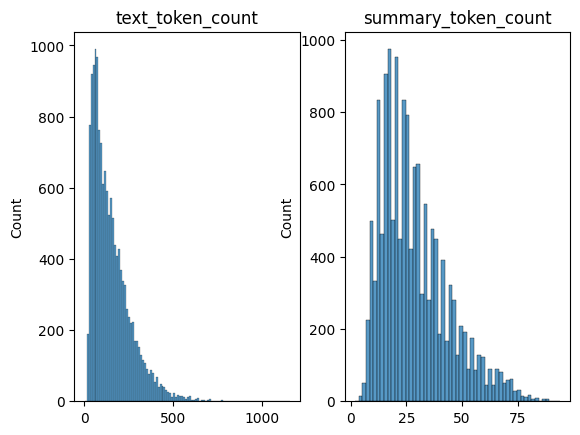

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)
sns.histplot(text_token_counts, ax=ax1)
ax1.set_title('text_token_count')

sns.histplot(summary_token_counts, ax=ax2)
ax2.set_title('summary_token_count')

In [14]:
n_epochs=3
batch_size=4

data_module=dialogueSummaryDataModule(train_df,test_df,val_df,tokenizer,batch_size=batch_size)


In [15]:
class dialogueSummaryModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(Model_name, return_dict=True)

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):

        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def test_step(self,batch, batch_idx):
        input_ids=batch['text_input_ids']
        attention_mask=batch['text_attention_mask']
        labels=batch['labels']
        labels_attention_mask=batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log('test_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids=batch['text_input_ids']
        attention_mask=batch['text_attention_mask']
        labels=batch['labels']
        labels_attention_mask=batch['labels_attention_mask']

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)


In [ ]:
model = dialogueSummaryModel()

In [ ]:
from lightning_utilities.core.imports import RequirementCache

print(RequirementCache("tensorboard"))
print(RequirementCache("tensorboardx"))

Requirement 'tensorboard' met
DistributionNotFound: The 'tensorboardx' distribution was not found and is required by the application. HINT: Try running `pip install -U 'tensorboardx'`


In [ ]:
import torch
print(torch.cuda.device_count())

1


In [ ]:
checkpoint_callback=ModelCheckpoint(
    dirpath='./t5_model',
    filename='t5_base',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)


In [ ]:
trainer = pl.Trainer(accelerator='gpu',callbacks=checkpoint_callback, max_epochs=n_epochs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jklab/anaconda3/envs/eng_sum/lib/python3.8/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params

Sanity Checking: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/home/jklab/anaconda3/envs/eng_sum/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the enviro

/home/jklab/anaconda3/envs/eng_sum/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 3683: 'val_loss' reached 1.40975 (best 1.40975), saving model to '/home/jklab/Research/code/Bart/data/samsum/t5_model/t5_base.ckpt' as top 1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

Epoch 1, global step 7366: 'val_loss' reached 1.38147 (best 1.38147), saving model to '/home/jklab/Research/code/Bart/data/samsum/t5_model/t5_base.ckpt' as top 1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

Epoch 2, global step 11049: 'val_loss' was not in top 1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

Epoch 3, global step 14732: 'val_loss' was not in top 1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

Epoch 4, global step 18415: 'val_loss' was not in top 1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

Epoch 5, global step 22098: 'val_loss' was not in top 1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

Epoch 6, global step 25781: 'val_loss' was not in top 1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

Epoch 7, global step 29464: 'val_loss' was not in top 1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

Epoch 8, global step 33147: 'val_loss' was not in top 1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Validation: 0it [00:00, ?it/s]

Epoch 9, global step 36830: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
trained_model=dialogueSummaryModel.load_from_checkpoint("./t5_model/t5_base.ckpt")

trained_model.freeze()
trained_model.to('cuda:0')

dialogueSummaryModel(
  (model): T5ForConditionalGeneration(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(i

In [17]:
def summarize(text):
  text_encoding=tokenizer(
      text,
      max_length=512,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors='pt'
  )

  generated_ids=trained_model.model.generate(
      input_ids=text_encoding['input_ids'].to('cuda:0'),
      attention_mask=text_encoding['attention_mask'].to('cuda:0'),
      max_length=150,
      num_beams=2,
      repetition_penalty=2.5,
      length_penalty=1.0,
      early_stopping=True
  )

  preds =[
          tokenizer.decode(gen_id,skip_special_tokens=True,clean_up_tokenization_spaces=True)
          for gen_id in generated_ids
  ]
  return " ".join(preds)

In [18]:
sample_row=test_df.iloc[0]
text=sample_row['dialogue']
model_summary=summarize(text)

In [19]:
text

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [20]:
test_df.loc[0, 'summary']

"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."

In [21]:
model_summary

"Hannah wants Amanda to text Betty's number."

In [25]:
sample_row=test_df.iloc[1]
text1=sample_row['dialogue']
model_summary=summarize(text1)

In [27]:
text1

"Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I'll check.\r\nEric: Sure.\r\nRob: Turns out no! There are some of his stand-ups on youtube.\r\nEric: Gr8! I'll watch them now!\r\nRob: Me too!\r\nEric: MACHINE!\r\nRob: MACHINE!\r\nEric: TTYL?\r\nRob: Sure :)"

In [28]:
model_summary

'Eric and Rob are watching a stand-up on MACHINE.'

In [29]:
test_df.loc[1, 'summary']

'Eric and Rob are going to watch a stand-up on youtube.'

In [33]:
sample_row=test_df.iloc[2]
text2=sample_row['dialogue']
model_summary=summarize(text2)

In [34]:
text2

"Lenny: Babe, can you help me with something?\r\nBob: Sure, what's up?\r\nLenny: Which one should I pick?\r\nBob: Send me photos\r\nLenny:  <file_photo>\r\nLenny:  <file_photo>\r\nLenny:  <file_photo>\r\nBob: I like the first ones best\r\nLenny: But I already have purple trousers. Does it make sense to have two pairs?\r\nBob: I have four black pairs :D :D\r\nLenny: yeah, but shouldn't I pick a different color?\r\nBob: what matters is what you'll give you the most outfit options\r\nLenny: So I guess I'll buy the first or the third pair then\r\nBob: Pick the best quality then\r\nLenny: ur right, thx\r\nBob: no prob :)"

In [35]:
model_summary

'Lenny wants to buy the first or the third pair of black trousers.'

In [36]:
test_df.loc[2,'summary']

"Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality."

In [37]:
sample_row=test_df.iloc[3]
text3=sample_row['dialogue']
model_summary=summarize(text3)

In [38]:
text3

"Will: hey babe, what do you want for dinner tonight?\r\nEmma:  gah, don't even worry about it tonight\r\nWill: what do you mean? everything ok?\r\nEmma: not really, but it's ok, don't worry about cooking though, I'm not hungry\r\nWill: Well what time will you be home?\r\nEmma: soon, hopefully\r\nWill: you sure? Maybe you want me to pick you up?\r\nEmma: no no it's alright. I'll be home soon, i'll tell you when I get home. \r\nWill: Alright, love you. \r\nEmma: love you too. "

In [39]:
model_summary

"Emma doesn't want to cook dinner tonight. She will be home soon."

In [40]:
test_df.loc[3,'summary']

'Emma will be home soon and she will let Will know.'

In [41]:
sample_row=test_df.iloc[4]
text4=sample_row['dialogue']
model_summary=summarize(text4)

In [42]:
text4

'Ollie: Hi , are you in Warsaw\r\nJane: yes, just back! Btw are you free for diner the 19th?\r\nOllie: nope!\r\nJane: and the  18th?\r\nOllie: nope, we have this party and you must be there, remember?\r\nJane: oh right! i lost my calendar..  thanks for reminding me\r\nOllie: we have lunch this week?\r\nJane: with pleasure!\r\nOllie: friday?\r\nJane: ok\r\nJane: what do you mean " we don\'t have any more whisky!" lol..\r\nOllie: what!!!\r\nJane: you just call me and the all thing i heard was that sentence about whisky... what\'s wrong with you?\r\nOllie: oh oh... very strange! i have to be carefull may be there is some spy in my mobile! lol\r\nJane: dont\' worry, we\'ll check on friday.\r\nOllie: don\'t forget to bring some sun with you\r\nJane: I can\'t wait to be in Morocco..\r\nOllie: enjoy and see you friday\r\nJane: sorry Ollie, i\'m very busy, i won\'t have time for lunch  tomorrow, but may be at 6pm after my courses?this trip to Morocco was so nice, but time consuming!\r\nOllie: 

In [43]:
model_summary

'Jane is in Warsaw. Ollie and Jane are having a party on Friday. They will meet at 6 pm after their courses.'

In [44]:
test_df.loc[4, 'summary']

"Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm."

In [45]:
text10 = ['Mike: Hey, How are you?\n', 'Ami: I think something makes me depressed.\n','Mike: What is wrong with you?\n', 'Ami: Actually, I did not pass the exam.\n',
        'Mike: I am so sorry. You should pass the next exam.\n', 'Ami: Thank you. You make me pleasure. I will study hard for passing the exam.\n', 'Mike: Yes, you are so smart.\n',
        'Ami: Thank you. We will make an appointment for having a lunch. Bye!\n', 'Mike: Of Course. Bye!\n']

In [46]:
model_summary=summarize(text10)

In [47]:
model_summary

"Mike is looking forward to hearing from you. Ami thinks something makes her depressed. Mike is not happy with him. Ami didn't pass the exam. Mike is sorry that you should pass the next exam. Ami will study hard for passing the exam. Mike thinks Mike is smart. Ami will make an appointment for having lunch. Mike will be bye."

In [51]:
text11 = ['Mike: Hey, How do you feel today?\n', 'Ami: Thesedays, I really feel so bad.\n',
          "Mike: What's your problem?\n", "Ami: My parents made me angry. They always want to study hard.\n",
          "Mike: Oh, That't too bad. Do you know why they are doing?\n", "Ami: I don't know exactly why they do so.\n",
          "Mike: Um.. How about talking about their idea. If you know their, you will feel better.\n", "Ami: I am not sure that my feeling will get better.\n",
          "Mike: I understand you. However, relationship between them and you need to be improved. Then, your family have a strong relationship.\n", "Ami: Ok. I will try it. Thank you!\n"]

In [52]:
model_summary=summarize(text11)

In [53]:
model_summary

"Mike asks how do you feel today. Ami feels bad these days. Mike asks what's the problem with you. Ami's parents made her angry. Mike is not sure why they are doing it. Ami doesn't know why they do it. Mike suggests talking about their idea. Ami is not sure if her feeling will get better. Mike understands that the relationship between Mike and his family needs to improve. Ami will try it."

In [57]:
text12 = ["Scott: Do you know Kath's e-mail address?\n", "Mike: Um. Let me find it. I sent a e-mail to her for three days ago.\n",
          "Scott: Oh. That's good. Let me know it.", "Mike: Yes, I text you his e-mail address.\n",
          "Scott: Thank you! You're a good friend.\n", "Mike: You're welcome. Have a nice day!\n"]

In [58]:
model_sumamry=summarize(text12)

In [59]:
model_sumamry

"Kath's e-mail address is Scott's. Mike sent her an e-mail three days ago. Scott will let him know if it's okay. Mike sends Mike his e-mail address. Scott is a good friend. Mike wishes you a nice day."

In [60]:
text13 = ['Chatbot: How are you doing? Do you get better your circumstance?\n', 'User: Yes, I have a close relationship with my classmates.\n',
          'Chatbot: Oh, Congraturations! What do you hang out with them?\n', 'User: After class, we are going to eat some snacks with cocke.\n',
          'Chatbot: That is right. I am sure that you will have a lot of good memories with them.\n', 'User: I really hope so. Thank you.\n',
          "Chatbot: You're wellcome. You text me if you have a problem about life. I will try to solve it with you.\n", 'User: Really Thank you. Bye!\n']

In [61]:
model_summary=summarize(text13)

In [62]:
model_summary

'Chatbot asks how are you doing. User has a close relationship with his classmates. Chatbot congratulates her. After class, we are going to eat some snacks with cocke. Chatbot is sure that you will have a lot of good memories. User hopes so. Chatbot will try to solve a problem with you. User is very grateful.'